In [1]:
import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")


df = pd.read_csv('processed_data.csv')

df_majority = df[df['Privacy Exists']==0]
df_minority = df[df['Privacy Exists']==1]
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=2750,     # to match minority class
                                 random_state=123) # reproducible results
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

X = df_downsampled.iloc[:, 1:-1].values
Y = df_downsampled.iloc[:, -1:].values


scaler = StandardScaler(); X = scaler.fit_transform(X)

X_new = SelectKBest(f_classif, k=80).fit_transform(X, Y)

X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.3, random_state = 5)

In [2]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
models = {
    'Gradient Boosting': GradientBoostingClassifier()
}

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


for name, model in models.items():
    print('Training', name)

    clf = model
    clf = clf.fit(X_train, y_train)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    scores_train = cross_val_score(clf, y_train, y_pred_train, cv=10)
    print('train cross val',scores_train.mean())
    scores_test = cross_val_score(clf, y_test, y_pred_test, cv=10)
    print('test cross val',scores_test.mean())

    scores_train = accuracy_score(y_train, y_pred_train)
    print('train acc',scores_train.mean())
    scores_test = accuracy_score(y_test, y_pred_test)
    print('test acc',scores_test.mean())

Training Gradient Boosting
train cross val 0.7847629643084189
test cross val 0.7201612903225806
train acc 0.7847508945774841
test acc 0.7201540436456996


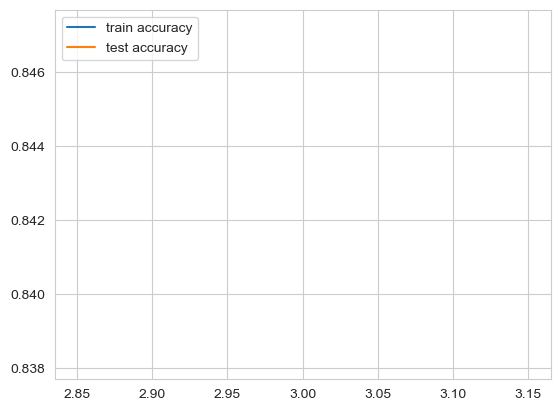

In [36]:
#hyperparameter Tune!!!!!!!!!!!!!!!!

import seaborn as sns

train_accs_cross = []
test_accs_cross = []

train_accs_asaf = []
test_accs_asaf = []

"""
model = GradientBoostingClassifier(learning_rate=0.1,
                                   n_estimators=100,
                                   max_depth=3,
                                   subsample=0.8,
                                   min_samples_split=2,
                                   alpha=0.9,
                                   lambda=0.5)
"""

#rng = list(range(52,89,2))
#rng = [i / 100 for i in range(1,9)]
#rng = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
rng = [3]

for eta in rng:

    clf = GradientBoostingClassifier(learning_rate=0.01,
                                    n_estimators=60,
                                    max_depth=2,
                                    subsample=0.7,
                                    min_samples_split=eta,
                                    max_features=68)
    clf = clf.fit(X_train, y_train)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    scores_train_cross = cross_val_score(clf, y_train, y_pred_train, cv=3).mean()
    scores_test_cross = cross_val_score(clf, y_test, y_pred_test, cv=3).mean()
    
    scores_train_asaf = accuracy_score(y_train, y_pred_train).mean()
    scores_test_asaf = accuracy_score(y_test, y_pred_test).mean()

    train_accs_cross.append(scores_train_cross)
    test_accs_cross.append(scores_test_cross)

    train_accs_asaf.append(scores_train_asaf)
    test_accs_asaf.append(scores_test_asaf)

plt.figure()
sns.set_style("whitegrid")
plt.plot(rng,train_accs_cross, label="train accuracy")
plt.plot(rng,test_accs_cross, label="test accuracy")
plt.legend(loc="upper left")
plt.show()

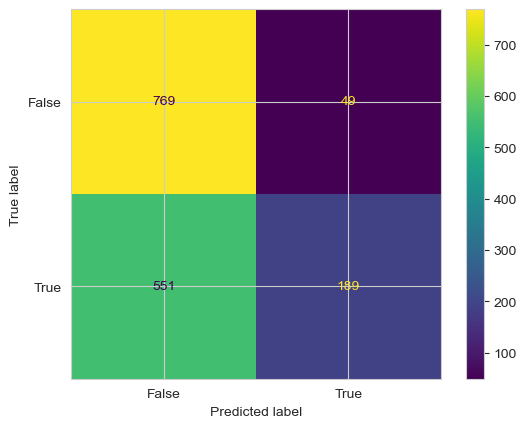

<Figure size 640x480 with 0 Axes>

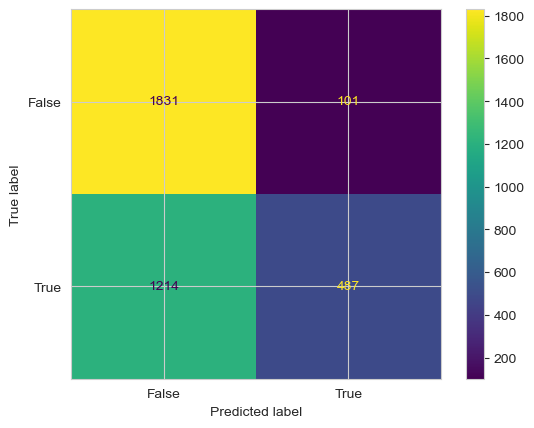

In [37]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_test, display_labels = [False, True])
cm_display.plot()
plt.show()
plt.figure()

confusion_matrix_train = confusion_matrix(y_train, y_pred_train)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_train, display_labels = [False, True])
cm_display.plot()
plt.show()

In [38]:
#Who is Best!!!
max_value = max(test_accs_cross)
max_index = test_accs_cross.index(max_value)

print("Maximum value:", max_value)
print("Index of maximum value:", max_index)
print(list(rng)[max_index])

Maximum value: 0.847240748974853
Index of maximum value: 0
3


In [41]:
from scipy.stats import loguniform
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    "learning_rate": loguniform(0.01, 1),
}
search_cv = RandomizedSearchCV(
    GradientBoostingRegressor(), param_distributions=param_distributions,
    scoring="neg_mean_absolute_error", n_iter=20, random_state=0, n_jobs=2
)
search_cv.fit(X_train, y_train)

columns = [f"param_{name}" for name in param_distributions.keys()]
columns += ["mean_test_error", "std_test_error"]
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results["mean_test_error"] = -cv_results["mean_test_score"]
cv_results["std_test_error"] = cv_results["std_test_score"]
cv_results[columns].sort_values(by="mean_test_error")


error = -search_cv.score(X_test, y_test)
print(error)

0.39067812449548484
